In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

import os

import numpy as np

from pathlib import Path

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint #type: ignore
from tensorflow.keras.layers import BatchNormalization, Conv2D, Dropout, Dense, Flatten, MaxPool2D # type: ignore
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam #type: ignore
from tensorflow.keras.regularizers import l2 #type: ignore

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from scipy.ndimage import median_filter

from PIL import Image

# Constants
BD_PATH = "Dogs/Bacterial_dermatosis"
FI_PATH = "Dogs/Fungal_infections"
H_PATH = "Dogs/Healthy"
H_A_D_PATH = "Dogs/Hypersensitivity_allergic_dermatosis"
EPOCHS = 100
IMG_SIZE = (128, 128)  
FILTER_SIZE = 3
BATCH_SIZE = 32
LEARNING_RATE = 0.001
PATIENCE = 7
SEED = 12

# Random seeds for reproducibility
np.random.seed(SEED)
tf.random.set_seed(SEED)

def get_image_paths(folder):
    # Return list of paths to images found in specified folder.
    if not os.path.exists(folder):
        raise FileNotFoundError(f"The directory {folder} does not exist.")
    return sorted([
        Path(folder) / p for p in os.listdir(folder)
        if p.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))
        and not p.startswith('.')
    ])

def load_and_process_image(path, size=IMG_SIZE):
    # Load image from path and resize it to required size.
    try:
        img = Image.open(path).convert("RGB")
        img = img.resize(size)
        
        img = np.array(img)
        
        # Apply median filter
        img = median_filter(img, size=FILTER_SIZE)
        
        return img
    except Exception as e:
        print(f"Error loading image {path}: {e}")
        return None

def load_images_and_labels(paths, label):
    # Load images and labels from specified paths.
    images = [load_and_process_image(p) for p in paths]
    images = [img for img in images if img is not None]  # Remove failed loads
    labels = [label] * len(images)
    return images, labels

def load_data():
    # Load and prepare the dataset.
    bds_paths = get_image_paths(BD_PATH)
    fi_paths = get_image_paths(FI_PATH)
    h_paths = get_image_paths(H_PATH)
    h_a_d_paths = get_image_paths(H_A_D_PATH)

    bds_images, bds_labels = load_images_and_labels(bds_paths, 0)
    fi_images, fi_labels = load_images_and_labels(fi_paths, 1)
    h_images, h_labels = load_images_and_labels(h_paths, 2)
    h_a_d_images, h_a_d_labels = load_images_and_labels(h_a_d_paths, 3)

    images = np.array(bds_images + fi_images + h_images + h_a_d_images)
    labels = np.array(bds_labels + fi_labels + h_labels + h_a_d_labels)

    return train_test_split(images, labels, test_size=0.2, random_state=SEED, shuffle=True)

def create_model():
    # CNN Network Model with regularisation
    model = Sequential([
        # Layer 1: 
        # Image Size: 128 x 128    
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='gelu', padding='same', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), kernel_regularizer=l2(0.01)),
        MaxPool2D(2, 2),
        Dropout(0.2),

        # Layer 2: 
        # Image Size: 64 x 64 x 64
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='gelu', padding='same', kernel_regularizer=l2(0.01)),
        MaxPool2D(2, 2),
        Dropout(0.2),
        
        # Layer 3: 
        # Image Size: 32 x 32 x 32
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='gelu', padding='same', kernel_regularizer=l2(0.01)),
        MaxPool2D(2, 2),
        Dropout(0.2),

        # Layer 4: 
        # Image Size: 16 x 16 x 16
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='gelu', padding='same', kernel_regularizer=l2(0.01)),
        MaxPool2D(2, 2),
        Dropout(0.2),
        
        # Layer 5: 
        # Image Size: 8 x 8 x 8
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='gelu', padding='same', kernel_regularizer=l2(0.01)),
        MaxPool2D(2, 2),
        Dropout(0.2),
        
        # Layer 6: 
        # Image Size: 4 x 4 x 4
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='gelu', padding='same', kernel_regularizer=l2(0.01)),
        MaxPool2D(2, 2),
        Dropout(0.2),

        # Layer 7: 
        # Image Size: 2 x 2 x 2
        Flatten(),
        Dense(256, activation='gelu'),
        Dropout(0.2),
        Dense(4, activation='softmax')  # 4 classes
    ])
    optimizer = Adam(learning_rate=LEARNING_RATE)  # Adjust learning rate
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255, # Normalisation
    rotation_range=30, # To capture more different angles
    
    # 10% Tolerance Range
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    
    # Account for Image Flipping
    horizontal_flip=True,
    vertical_flip=True,
    
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Load and prepare the dataset
images_train, images_test, labels_train, labels_test = load_data()
val_generator = val_datagen.flow(images_test, labels_test, batch_size=BATCH_SIZE)

train_generator = train_datagen.flow(
    images_train, labels_train,
    batch_size=BATCH_SIZE  # Adjust batch size
)

model = create_model()

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=PATIENCE, 
    restore_best_weights=True
)
checkpoint = ModelCheckpoint(
    'alt_model.keras', 
    monitor='val_accuracy', 
    save_best_only=True
)

# Train the model
history = model.fit(
    train_generator,
    
    # Matching the steps_per_epoch to Batch size to ensure that the 
    # model is trained on the entire dataset.
    steps_per_epoch=int(np.ceil(len(images_train) / BATCH_SIZE)),
    
    epochs=EPOCHS,  # Adjust number of epochs
    
    validation_data=val_generator,
    callbacks=[checkpoint]
)


/Users/yuna.kumar-shono/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/yuna.kumar-shono/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


TypeError: 'numpy.float64' object cannot be interpreted as an integer

3/3 [==============================] - 2s 153ms/step


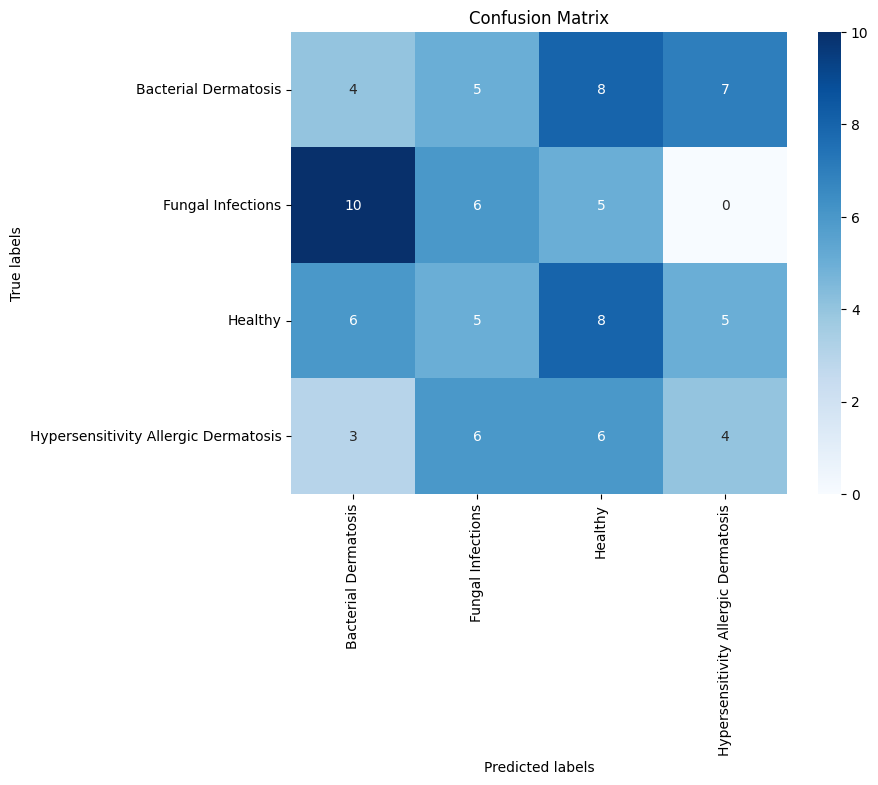

In [2]:
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

# Predicted labels
predictions = model.predict(val_generator, steps=np.ceil(len(images_test) / BATCH_SIZE))
predicted_labels = np.argmax(predictions, axis=1)  # Gives class with the highest probability

# True labels
true_labels = labels_test

class_names = ['Bacterial Dermatosis', 'Fungal Infections', 'Healthy', 'Hypersensitivity Allergic Dermatosis']

plot_confusion_matrix(true_labels, predicted_labels, class_names)

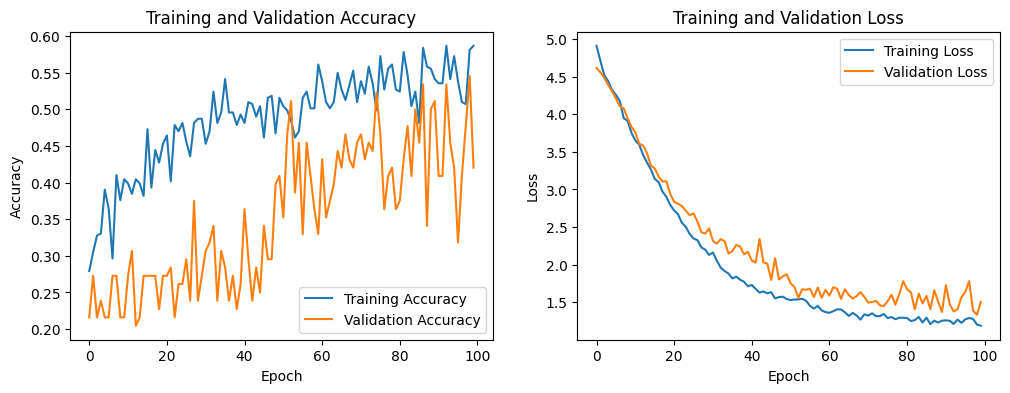

In [3]:
# Accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()